In [64]:
import random
import numpy as np
import matplotlib
import time
from numba import jit
import multiprocessing as mp
from matplotlib import pyplot as plt

In [65]:
@jit(nopython=True)
def demand(p1, p2):
    if p1 < p2:
        d = 1 - p1
    elif p1 == p2:
        d = 0.5 * (1 - p1)
    else:
        d = 0
    return d

In [66]:
@jit(nopython=True)
def profit(p1, p2):
    return (p1 * demand(p1, p2))

In [67]:
P = np.array([0, 1/6, 2/6, 3/6, 4/6, 5/6, 1]) # price array

In [68]:
@jit(nopython=True)
def epsilon_greedy(Qtable, epsilon, uniform, state: int, price_grid: np.ndarray) -> int: 
    N = len(price_grid)
    assert Qtable.shape[0] == N, "Qtable must have the same number of rows as there are prices in the grid"
    assert Qtable.shape[1] == N, "Qtable must have the same number of columns as there are prices in the grid"
    assert state < N, "state must be a valid index in the price grid"
    assert state >= 0, "state must be a valid index in the price grid"

    # Draw action 
    if uniform < epsilon:
        price_index = np.random.choice(N)
    else:
        price_index = np.argmax(Qtable[:, state])
    return price_index

In [92]:
@jit(nopython=True)
def epsilon_greedy1(expected_profit, epsilon, uniform, price_grid: np.ndarray) -> int: 
    N = len(price_grid)

    # Draw action 
    if uniform < epsilon:
        price_index = np.random.choice(N)
    else:
        price_index = np.argmax(expected_profit)
    return price_index

In [93]:
# Probability array for opponents choice
@jit(nopython=True)
def prob_array(Qtable, price_grid, price_index_i):
    K = len(price_grid)
    prob_matrix = np.zeros((K, K))

    # [Anders] a faster way of doing the below is 
    # prob_matrix = Qtable / np.sum(Qtable, axis=1)[:, None]

    prob_matrix[price_index_i] = Qtable[price_index_i, :] / np.sum(Qtable[price_index_i, :])

    return prob_matrix

In [82]:
@jit(nopython=True)
def update_Qtable(Qtable, price_index_i, state, price_index_j_next_period, profit_i_current_period, profit_i_next_period, delta, alpha):
    max_Q = np.max(Qtable[:, price_index_j_next_period])
    continuation_value = max_Q 

    new_estimate = profit_i_current_period + delta * profit_i_next_period + delta**2 * continuation_value

    # Update
    prev_estimate = Qtable[price_index_i, state]

    # Update Q-table for player i
    Qtable[price_index_i, state] = (1 - alpha) * prev_estimate + alpha * new_estimate
      

In [94]:
@jit(nopython=True)
def expected_profit_sequential(idx_state:int, price_grid, prob_opponent, discount_factor: float): 
    K = len(price_grid)
    expected_profit = np.zeros(K)

    # verify that the prob_opponent makes sense 
    assert prob_opponent.shape == (K,K)
    #assert np.isclose(prob_opponent.sum(axis=1) , 1.0).all()

    for i in range(K): # my price 
        profit_now = profit(price_grid[i], price_grid[idx_state]) # opponent cannot update price yet 
        profit_next = np.zeros(K)
        for j in range(K): 
            profit_next[j] = profit(price_grid[i], price_grid[j]) # I cannot update next period 

        this_prob_opponent = prob_opponent[i,:] # my opponent will respond to my price with this probability vector 
        expected_profit[i] = profit_now + discount_factor * np.sum(profit_next * this_prob_opponent)
    
    return expected_profit 

In [96]:
@jit(nopython=True)
def game_Qlearner(price_grid, periods, delta, alpha, theta):
     # Initialize prices and Q-tables
    price_index_1 = np.random.choice(len(price_grid)) 
    price_index_2 = np.random.choice(len(price_grid)) 
 
    Qtable_1 = np.zeros((len(price_grid), len(price_grid)))
    Qtable_2 = np.zeros((len(price_grid), len(price_grid)))

    profit_1 = np.zeros(int(periods))
    profit_2 = np.zeros(int(periods))

    avg_profit = np.zeros(periods)

    epsilons = (1 - theta)**np.arange(periods + 1)
    uniforms = np.random.uniform(0, 1, (periods + 1, 2))

    for t in range(1, periods + 1):
        #print("T = ", t)
        if t % 2 != 0:
            state = price_index_2
            # current period 
            decision = price_grid[price_index_1]
            state_1_responds_to = price_grid[state]
            profit_1_current_period = profit(decision, state_1_responds_to)

            # next period 
            state_next_period = price_index_1 # next_period's state is today's price
            price_index_2_next_period = epsilon_greedy(Qtable_2, epsilons[t], uniforms[t,0], state=state_next_period, price_grid=price_grid)

            price_2_next_period = price_grid[price_index_2_next_period]
            price_1_next_period = price_grid[price_index_1] # unchanged price, it's not i's turn 
            profit_1_next_period = profit(price_1_next_period, price_2_next_period)

            update_Qtable(Qtable_1, price_index_1, state, price_index_2_next_period, profit_1_current_period, profit_1_next_period, delta, alpha)

            # Profit opponent 
            profit_opponent = profit(state_1_responds_to, decision)
        
            # Profit
            avg_profit[t-1] = (profit_1_current_period + profit_opponent) / 2

            profit_1[t-1] = profit_1_current_period
            profit_2[t-1] = profit_opponent

            price_index_2 = price_index_2_next_period
        
        else:
            state = price_index_1
            # current period 
            decision = price_grid[price_index_2]
            state_2_responds_to = price_grid[state]
            profit_2_current_period = profit(decision, state_2_responds_to)

            # next period 
            state_next_period = price_index_2 # next_period's state is today's price
            price_index_1_next_period = epsilon_greedy(Qtable_1, epsilons[t], uniforms[t,1], state=state_next_period, price_grid=price_grid)

            price_1_next_period = price_grid[price_index_1_next_period]
            price_2_next_period = price_grid[price_index_2] # unchanged price, it's not i's turn 
            profit_2_next_period = profit(price_2_next_period, price_1_next_period)

            update_Qtable(Qtable_2, price_index_2, state, price_index_1_next_period, profit_2_current_period, profit_2_next_period, delta, alpha)

            # Profit opponent 
            profit_opponent = profit(state_2_responds_to, decision)
        
            # Profit
            avg_profit[t-1] = (profit_2_current_period + profit_opponent) / 2

            profit_1[t-1] = profit_opponent
            profit_2[t-1] = profit_2_current_period

            price_index_1 = price_index_1_next_period
           
        
    return avg_profit, profit_1, profit_2

In [103]:
@jit(nopython=True)
def FictitiousPlay(price_grid, delta, t, epsilons, uniforms, count, price_index_opponent, price_index_i):
    # Update the action count for the chosen price
    count[price_index_i, price_index_opponent] += 1
    
    # Calculate the probability for the player's actions
    prob_opponent = prob_array(count, price_grid, price_index_i)

    # Calculate the expected profit for the player for each possible price
    expected_profit = expected_profit_sequential(price_index_opponent, price_grid, prob_opponent, delta)

    # Choose a new price based on the expected profit
    price_index_i = epsilon_greedy1(expected_profit, epsilons[t], uniforms[t, 1], price_grid)

    return price_index_i

In [104]:
@jit(nopython=True)
def game_FictitiousPlay(price_grid, periods, delta, alpha, theta):
    K = len(price_grid)

     # Initialize prices and Q-tables
    price_index_1 = np.random.choice(K) 
    price_index_2 = np.random.choice(K) 
    price_old_1 = np.random.choice(K) 
    price_old_2 = np.random.choice(K) 
 
    Qtable_1 = np.zeros((K, K))
    Qtable_2 = np.zeros((K, K))

    profit_1 = np.zeros(int(periods))
    profit_2 = np.zeros(int(periods))

    avg_profit = np.zeros(periods)

    epsilons = (1 - theta)**np.arange(periods + 1)
    uniforms = np.random.uniform(0, 1, (periods + 1, 2))

    count = np.zeros((K, K))

    for t in range(1, periods + 1):
        #print("T = ", t)
        if t % 2 != 0:
            state = price_index_2
            # current period 
            decision = price_grid[price_index_1]
            state_1_responds_to = price_grid[state]
            profit_1_current_period = profit(decision, state_1_responds_to)

            # next period 
            state_next_period = price_index_1 # next_period's state is today's price
            price_index_2_next_period = FictitiousPlay(price_grid, delta, t, epsilons, uniforms, count, price_index_2, price_old_1)

            price_old_1 = price_index_2_next_period 

            price_2_next_period = price_grid[price_index_2_next_period]
            price_1_next_period = price_grid[price_index_1] # unchanged price, it's not i's turn 
            profit_1_next_period = profit(price_1_next_period, price_2_next_period)

            update_Qtable(Qtable_1, price_index_1, state, price_index_2_next_period, profit_1_current_period, profit_1_next_period, delta, alpha)

            # Profit opponent 
            profit_opponent = profit(state_1_responds_to, decision)
        
            # Profit
            avg_profit[t-1] = (profit_1_current_period + profit_opponent) / 2

            profit_1[t-1] = profit_1_current_period
            profit_2[t-1] = profit_opponent

            price_index_2 = price_index_2_next_period
        
        else:
            state = price_index_1
            # current period 
            decision = price_grid[price_index_2]
            state_2_responds_to = price_grid[state]
            profit_2_current_period = profit(decision, state_2_responds_to)

            # next period 
            state_next_period = price_index_2 # next_period's state is today's price
            price_index_1_next_period = FictitiousPlay(price_grid, delta, t, epsilons, uniforms, count, price_index_1, price_old_2)

            price_old_2 = price_index_1_next_period 

            price_1_next_period = price_grid[price_index_1_next_period]
            price_2_next_period = price_grid[price_index_2] # unchanged price, it's not i's turn 
            profit_2_next_period = profit(price_2_next_period, price_1_next_period)

            update_Qtable(Qtable_2, price_index_2, state, price_index_1_next_period, profit_2_current_period, profit_2_next_period, delta, alpha)

            # Profit opponent 
            profit_opponent = profit(state_2_responds_to, decision)
        
            # Profit
            avg_profit[t-1] = (profit_2_current_period + profit_opponent) / 2

            profit_1[t-1] = profit_opponent
            profit_2[t-1] = profit_2_current_period

            price_index_1 = price_index_1_next_period
           
        
    return avg_profit, profit_1, profit_2

In [105]:
game_FictitiousPlay(P, 20, 0.95, 0.3, 0.0000276306)

(array([0.06944444, 0.06944444, 0.06944444, 0.06944444, 0.06944444,
        0.125     , 0.125     , 0.125     , 0.06944444, 0.06944444,
        0.06944444, 0.        , 0.        , 0.06944444, 0.06944444,
        0.        , 0.        , 0.06944444, 0.06944444, 0.06944444]),
 array([0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.125     , 0.25      , 0.13888889, 0.06944444,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.06944444, 0.13888889]),
 array([0.13888889, 0.13888889, 0.13888889, 0.13888889, 0.13888889,
        0.25      , 0.125     , 0.        , 0.        , 0.06944444,
        0.13888889, 0.        , 0.        , 0.13888889, 0.13888889,
        0.        , 0.        , 0.13888889, 0.06944444, 0.        ]))

In [106]:
@jit(nopython=True)
def Simulations(sim, price, period, delta, alpha, theta):
    total_profit_sim = np.zeros((sim, period))
    profit_1_sim = np.zeros((sim, period))
    profit_2_sim = np.zeros((sim, period))
    avg_profit = np.zeros(sim)
    avg_profit_1 = np.zeros(sim)
    avg_profit_2 = np.zeros(sim)

    for i in range(sim):
        total_profit_array, profit_1_array, profit_2_array = game_FictitiousPlay(price, period, delta, alpha, theta)
        total_profit_sim[i] = total_profit_array
        profit_1_sim[i] = profit_1_array
        profit_2_sim[i] = profit_2_array
        avg_profit_1[i] = np.mean(profit_1_array[-1000:])
        avg_profit_2[i] = np.mean(profit_2_array[-1000:])
        avg_profit[i] = np.mean(total_profit_array[-1000:])

    return total_profit_sim, avg_profit_1, avg_profit_2, profit_1_sim, profit_2_sim

In [107]:
start_time  = time.time()

total_profit_plot, avg_profit_1_plot, avg_profit_2_plot, profit_total_1, profit_total_2 = Simulations(1000, P, 500000, 0.95, 0.3, 0.0000276306)

end_time = time.time()

elapsed_time = end_time - start_time

print("Time taken to run 1000 simulations:", elapsed_time, "seconds")

Time taken to run 1000 simulations: 887.1312336921692 seconds


In [108]:
def delta_prof(avg_array_1, avg_array_2, sim):
    together_array = np.vstack((avg_array_1, avg_array_2))
    together_array_mean = np.mean(together_array, axis=0)
    delta_1 = np.zeros(len(together_array_mean))
    for i in range(sim):
        delta_1[i] = ((together_array_mean[i]) / (0.125))
    return delta_1

In [109]:
#dividing delta into intervals
def delta_div(delta_arr):
    new_delt = np.zeros(5)
    for i in range(len(delta_arr)):
        if delta_arr[i] <=1 and delta_arr[i] > 0.9: 
        #if delta_arr[i] == 1 :
            new_delt[4]+=1
        elif delta_arr[i] <=0.9 and delta_arr[i] > 0.8:
            new_delt[3]+=1
        elif delta_arr[i] <=0.8 and delta_arr[i] > 0.7:
            new_delt[2]+=1
        elif delta_arr[i] <= 0.7 and delta_arr[i] > 0.6:
            new_delt[1]+=1
        else:
            new_delt[0] +=1
    return new_delt

In [110]:
delta_1 = delta_prof(avg_profit_1_plot, avg_profit_2_plot, 1000)

delta_2 = delta_div(delta_1)

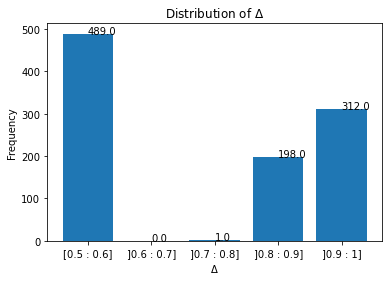

In [111]:
def addlabels(x,y):
    for i in range(len(x)):
        plt.text(i,y[i],y[i])

langs = ['[0.5 : 0.6]', ']0.6 : 0.7]', ']0.7 : 0.8]', ']0.8 : 0.9]', ']0.9 : 1]']

y_pos = np.arange(len(langs))

plt.title("Distribution of $\Delta$")
# Create bars
plt.bar(y_pos, delta_2)

addlabels(langs, delta_2 )
# Create names on the x-axis
plt.xticks(y_pos, langs)
plt.xlabel("$\Delta$")
plt.ylabel("Frequency")
#make label
label = [delta_2]
# Show graphic
plt.show()

In [112]:
samlet_prof = total_profit_plot.mean(0)
window_size = 1000
  
i = 0
# Initialize an empty list to store moving averages
moving_averages = []
# Loop through the array t o
#consider every window of size 1000
while i < len(samlet_prof) - window_size + 1:
  
    # Calculate the average of current window
    window_average = np.sum(samlet_prof[i:i+window_size]) / window_size
      
    # Store the average of current
    # window in moving average list
    moving_averages.append(window_average)
      
    # Shift window to right by one position
    i += 1

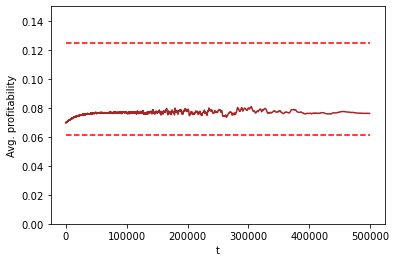

In [113]:
plt.plot(moving_averages, color='#a62626', label="Average profitability")
plt.xlabel('t')
plt.ylabel('Avg. profitability')
plt.ylim(0.00, 0.15)
plt.hlines(y=0.0611, xmin=0, xmax=500000, colors='red', linestyles='--')
plt.hlines(y=0.125, xmin=0, xmax=500000, colors='red', linestyles='--')
plt.show()